$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\tr}{\textrm{Tr}}
$$

## LGSSM (Kalman Filtering and Smoothing) Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="white", color_codes=True)

### Prepare data

In [2]:
ssm_spins = np.array(np.loadtxt('../data/ssm_spins.txt'))
ssm_spins_test = np.array(np.loadtxt('../data/ssm_spins_test.txt'))

In [3]:
def init_params_true(K, D):
    A = 0.99 * np.array([
        [np.cos(2 * np.pi / 180), -np.sin(2 * np.pi / 180), 0, 0],
        [np.sin(2 * np.pi / 180), np.cos(2 * np.pi / 180), 0, 0],
        [0, 0, np.cos(2 * np.pi / 90), -np.sin(2 * np.pi / 90)],
        [0, 0, np.sin(2 * np.pi / 90), np.cos(2 * np.pi / 90)]
    ])

    C = np.array([
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [1, 0, 0, 1],
        [0, 0, 1, 1],
        [0.5, 0.5, 0.5, 0.5]
    ])

    D, K = C.shape

    Q = np.eye(K) - np.dot(A, A.T)

    R = np.eye(D)

    m0 = np.random.randn(K)
    Q0 = np.eye(K)
    
    return m0, Q0, A, Q, C, R

In [4]:
def init_params_random(K, D):
    A = np.random.uniform(0, 1, size=(K, K))

    C = np.random.uniform(0, 1, size=(D, K))

    R = np.random.uniform(0, 1, size=(D, D))
    R = 0.5 * (R + R.T)
    R += D * np.eye(D)

    Q = np.random.uniform(0, 1, size=(K, K))
    Q = 0.5 * (Q + Q.T)
    Q += K * np.eye(K)

    Q0 = np.random.uniform(0, 1, size=(K, K))
    Q0 = 0.5 * (Q0 + Q0.T)
    Q0 += K * np.eye(K)

    m0 = np.random.randn(K)
    
    return m0, Q0, A, Q, C, R

In [5]:
def logdet(M):
    # T so upper triangular
    L = np.linalg.cholesky(M).T
    return 2 * np.sum(np.log(np.diag(L)))

In [6]:
def ssm_kalman(X, m0, Q0, A, Q, C, R, mode='smooth'):
    T = X.shape[0]
    if T < 2:
        print("Expect at least two time steps.")
        return
    
    D, K = C.shape
    m0 = m0.ravel()
    
    if  ((m0.shape != (K,)) 
        or (Q0.shape != (K, K))
        or (A.shape != (K, K))
        or (Q.shape != (K, K))
        or (R.shape != (D, D))):
        print("Inconsistent parameter dimensions")
        return
    
    K_gs = []
    log_liks = []
    
    y_pred = m0  # y_t^{t-1}
    V_pred = Q0  # V_t^{t-1}

    V_preds = []  # V_t^{t-1}
    y_filts = []  # y_t^t
    V_filts = []  # V_t^t

    for t in range(T):
        V_preds.append(V_pred)
        
        x_pred_err = X[t] - C @ y_pred
        V_x_pred = C @ V_pred @ C.T + R
        
        K_g = np.linalg.solve(V_x_pred.T, (V_pred @ C.T).T).T

        y_filt = y_pred + K_g @ x_pred_err
        V_filt = V_pred - K_g @ C @ V_pred
        V_filt = 0.5 * (V_filt + V_filt.T)
    
        y_pred = A @ y_filt
        V_pred = A @ V_filt @ A.T + Q
        
        ll = -0.5 * logdet(2 * np.pi * V_x_pred) \
             -0.5 * np.linalg.solve(
             V_x_pred.T, x_pred_err).T @ x_pred_err
        
        y_filts.append(y_filt)
        V_filts.append(V_filt)
        K_gs.append(K_g)
        log_liks.append(ll)
    
    if mode == "filter":
        return np.array(y_filts), np.array(V_filts), \
            np.array([]), np.array(log_liks)
    else:
        # For clarity of time indexing, we pre-allocate these
        y_hats = [None] * T  # y_t^T
        V_hats = [None] * T  # V_t^T
        V_pair_hats = [None] * (T - 1)  # E[y_{t-1}y_t | x_{1:T}] 

        y_hat = y_filts[-1]
        V_hat = V_filts[-1]

        y_hats[-1] = y_hat
        V_hats[-1] = V_hat
    
        Js = []
        
        for t in range(T - 1 - 1, -1, -1):
            J = np.linalg.solve(V_preds[t + 1].T,
                                (V_filts[t] @ A.T).T).T
            y_hat = y_filts[t] \
                + J @ (y_hat - A @ y_filts[t])
            V_hat = V_filts[t] \
                + J @ (V_hat - V_preds[t+1]) @ J.T
        
            y_hats[t] = y_hat
            V_hats[t] = V_hat
            Js.append(J)
         
        V_pair_hats[-1] = (np.eye(K) - K_gs[-1] @ C) @ A @ V_filts[-2]
        for t in range(T - 1 - 2, -1, -1):
            V_pair_hats[t] = V_filts[t + 1] @ Js[t].T \
                + Js[t + 1] @ \
                (V_pair_hats[t + 1] - A @ V_filts[t + 1]) @ Js[t].T
        
        return np.array(y_hats), np.array(V_hats), \
               np.array(V_pair_hats), np.array(log_liks)

In [7]:
true_params = init_params_true(4, ssm_spins.shape[1])
Y, V, _, L = ssm_kalman(ssm_spins, *true_params, 'filter')

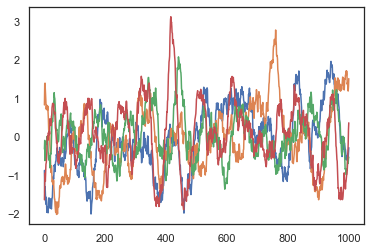

In [8]:
plt.plot(Y)
plt.show()

In [9]:
Y, V, V_pair, L = ssm_kalman(ssm_spins, *true_params, 'smooth')

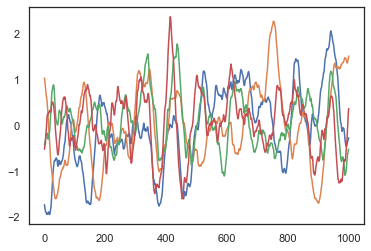

In [10]:
plt.plot(Y)
plt.show()

In [11]:
def E(data, *old_params):
    Y, V, V_pair, L = ssm_kalman(ssm_spins, *old_params, 'smooth')
    
    return {"Y": Y, "V": V, "V_pair": V_pair}, L

In [12]:
def M(data, *old_params, **expectations): 
    T, _ = data.shape
    
    Y, V, V_pair = expectations["Y"], expectations["V"], expectations["V_pair"]
    
    Mt = V + Y[..., None] @ Y[:, None, :]
    Mtt1 = V_pair + Y[1:, :, None] @ Y[:-1, None, :]
    
    A = np.linalg.solve(
        np.sum(Mt[:-1], axis=0).T,
        np.sum(Mtt1, axis=0).T
        ).T
    
    Q = 1 / (T - 1) * (
        np.sum(Mt[1:], axis=0) - A @ np.sum(Mtt1, axis=0).T) 
    
    C = np.linalg.solve(
        np.sum(Mt, axis=0).T,
        np.sum(data[..., None] @ Y[:, None, :], axis=0).T
        ).T
    
    R = 1 / T * (
        np.sum(data[..., None] @ data[:, None, :], axis=0)
        - C @ np.sum(Y[..., None] @ data[:, None, :], axis=0))
    
    m0 = Y[0]
    Q0 = V[0]
    
    return m0, Q0, A, Q, C, R 

In [13]:
def EM(data, K, init_random=True, max_iters=50):
    T, D = data.shape
    
    if init_random:
        params = init_params_random(K, D)
    else:
        params = init_params_true(K, D)
    
    lls = []
    
    for _ in range(max_iters):
        expectations, ll = E(data, *params)
        
        lls.append(np.sum(ll))
        
        params = M(data, *params, **expectations)
        
    return lls, params

In [14]:
ll, em_params = EM(ssm_spins, 4)

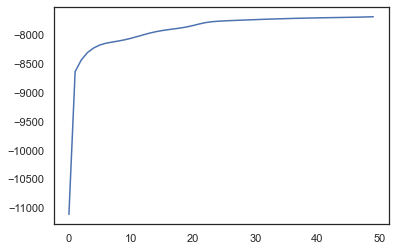

In [15]:
plt.plot(ll)
plt.show()